# Power spectrum level prediction accuracy.

In this noteboook we assess the prediction accuracy of the `EFTEMU` at the power spectrum level. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matryoshka.emulator as MatEmu
import matryoshka.halo_model_funcs as MatHM
import matryoshka.eft_funcs as MatEFT

In [2]:
path_to_matry = "/Users/jamie/Desktop/GitHubProjects/Matryoshka/"
path_to_repo = "/Users/jamie/Desktop/GitHubProjects/matryoshka_II_paper/"

We will be assess the prediction accuracy for 2000 unseen cosmologies, and with different sets of bias parameters. Those being the best fit LOW NGC, best fit CMASS NGC parameters, and radom draws from the prior defined in equation 35 of [D'Amico et al. (2020)](https://arxiv.org/abs/1909.05271).

We define the function for generating random bias parameters below.

In [3]:
def random_bias(N):
    b1 = np.random.uniform(0,4, size=N)
    
    c2 = np.random.uniform(-4,4, size=N)
    c4 = np.random.normal(loc=0,scale=2, size=N)
    
    b2 = 1/np.sqrt(2)*(c2+c4)
    b4 = 1/np.sqrt(2)*(c2-c4)
    
    b3 = np.random.normal(loc=0,scale=2, size=N)
    
    cct = np.random.normal(loc=0,scale=2, size=N)
    
    cr1 = np.random.normal(loc=0,scale=4, size=N)
    cr2 = np.random.normal(loc=0,scale=2, size=N)
    
    return np.vstack([b1, b2, b3, b4, cct, cr1, cr2]).T

We generate 2000 random draws from the prior, as such each cosmology will be tested with a different set of bias parameters.

In [4]:
bs_rand = random_bias(2000)

We define the best fit bias parameters, and convert $c_2$ and $c_4$ to $b_2$ and $b_4$.

In [5]:
bs_LOWZ = np.array([1.73, 1.0, -1.0, 0.0, 0.2, -10.03, 0., 0., 0., -2.1])
bs_CMASS = np.array([2.22, 1.2, 0.1, 0.0, 0.4, -7.7, 0., 0., 0., -3.7])

def c_to_b(c2, c4):
    return np.array([1/np.sqrt(2)*(c2+c4),1/np.sqrt(2)*(c2-c4)])

bs_LOWZ[[1,3]] = c_to_b(bs_LOWZ[1], bs_LOWZ[3])
bs_CMASS[[1,3]] = c_to_b(bs_CMASS[1], bs_CMASS[3])

We now load the full list of cosmologies, including training and test sets.

In [6]:
path_to_train = path_to_repo+"data/training/"
cosmos = np.load(path_to_train+"cosmologies/eft_cosmologies_noDQ1.npy")

In the loop below we load the full set of $P_n$ at each redshift along with the test ids. We then compute the multipoles for the three sets of bias parameters using the $P_n$ from `PyBird` and those predicted by the `EFTEMU`. Finally we plot the ratio of the `EFTEMU` and the `PyBird` predictions.

2022-10-12 17:56:26.937881: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.38
P0 max 2sigma error: 2.6772249764521416
P2 max 2sigma error: 4.009783424214852
0.51
P0 max 2sigma error: 3.8750855981674825
P2 max 2sigma error: 3.346095261232973
0.61
P0 max 2sigma error: 2.3352635731234583
P2 max 2sigma error: 5.498544357313739


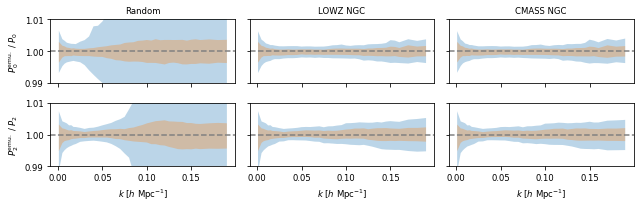

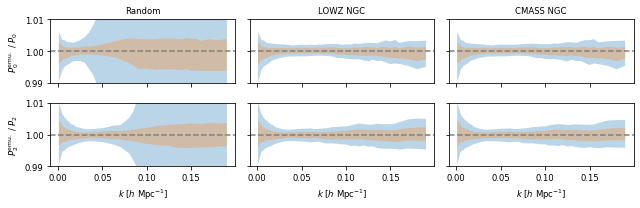

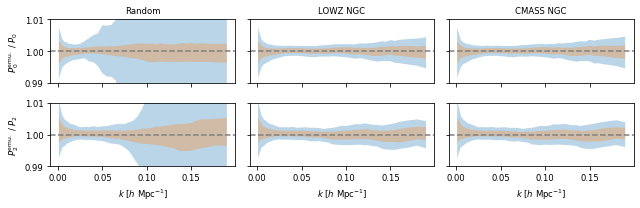

In [7]:
for zi in [0.38, 0.51, 0.61]:
    
    # Load Pn for P0 and P2
    P110_array = np.load(path_to_train+"z{z}/P110/P110_array-z{z}_noDQ1_optiresum-False.npy".format(z=zi))
    Ploop0_array = np.load(path_to_train+"z{z}/Ploop0/Ploop0_array-z{z}_noDQ1_optiresum-False.npy".format(z=zi))
    Pct0_array = np.load(path_to_train+"z{z}/Pct0/Pct0_array-z{z}_noDQ1_optiresum-False.npy".format(z=zi))
    P112_array = np.load(path_to_train+"z{z}/P112/P112_array-z{z}_noDQ1_optiresum-False.npy".format(z=zi))
    Ploop2_array = np.load(path_to_train+"z{z}/Ploop2/Ploop2_array-z{z}_noDQ1_optiresum-False.npy".format(z=zi))
    Pct2_array = np.load(path_to_train+"z{z}/Pct2/Pct2_array-z{z}_noDQ1_optiresum-False.npy".format(z=zi))
    
    # Load test ids.
    test_id = np.load(path_to_matry+"matryoshka-data/EFTv2/z{z}/split/test.npy".format(z=zi))
    
    # Compute growth rates.
    fs = MatHM.fN_vec((cosmos[:,0]+cosmos[:,1])/cosmos[:,2]**2, zi)
    
    # Initalise EFTEMU for zi.
    P0_emu = MatEmu.EFT(0, redshift=zi)
    P2_emu = MatEmu.EFT(2, redshift=zi)
    
    fig, ax = plt.subplots(2, 3, sharex=True, sharey='row', figsize=(9,3))
    
    # Some font formating.
    label_font = 8.5
    legend_font = 8.5
    for axi in ax.flatten():
        axi.tick_params(axis='both', which='major', labelsize=8.5)
        
    for i, (title, bs) in enumerate(zip(["Random", "LOWZ NGC", "CMASS NGC"],
                               [bs_rand, np.vstack(test_id.shape[0]*[bs_LOWZ[:7]]),
                                np.vstack(test_id.shape[0]*[bs_CMASS[:7]])])):

        # Calculate multipoles from PyBird Pn.
        P0_test = MatEFT.multipole_vec([P110_array[test_id], Ploop0_array[test_id], Pct0_array[test_id]], bs,
                                       fs[test_id].reshape(-1,1))
        P2_test = MatEFT.multipole_vec([P112_array[test_id], Ploop2_array[test_id], Pct2_array[test_id]], bs,
                                       fs[test_id].reshape(-1,1))

        # Predict multipoles with the EFTEMU.
        P0_preds = P0_emu.emu_predict(cosmos[test_id], bs)
        P2_preds = P2_emu.emu_predict(cosmos[test_id], bs)
        
        
        # Plot 1sigma and 2sigma regions.
        for level in [2.5,16]:
            ax[0,i].fill_between(P0_emu.P11.kbins,
                                 np.percentile(P0_preds/P0_test[:,:39], level, axis=0), 
                                 np.percentile(P0_preds/P0_test[:,:39], 100-level, axis=0),
                                 alpha=0.3)
            
            ax[1,i].fill_between(P0_emu.P11.kbins,
                                 np.percentile(P2_preds/P2_test[:,:39], level, axis=0), 
                                 np.percentile(P2_preds/P2_test[:,:39], 100-level, axis=0),
                                 alpha=0.3)
            
            # For the random bias parameters we print the maximum 2sigma error.
            # We do this because we will be imposing a ylim.
            if title=='Random' and level==2.5:
                
                P0_max_err = np.max((np.abs((np.percentile(P0_preds/P0_test[:,:39], level, axis=0).min()-1)*100),
                                    np.abs((np.percentile(P0_preds/P0_test[:,:39], 100-level, axis=0).max()-1)*100)))
                
                P2_max_err = np.max((np.abs((np.percentile(P2_preds/P2_test[:,:39], level, axis=0).min()-1)*100),
                                    np.abs((np.percentile(P2_preds/P2_test[:,:39], 100-level, axis=0).max()-1)*100)))
                
                print(zi)
                print("P0 max 2sigma error: {0}".format(P0_max_err))
                print("P2 max 2sigma error: {0}".format(P2_max_err))


        for j in range(2):
            ax[j,i].set_ylim(0.99,1.01)
            ax[j,i].axhline(1., color='grey', linestyle='--')

        ax[0,i].set_title(title, fontsize=label_font)
        ax[1,i].set_xlabel(r"$k \ [h \ \mathrm{Mpc}^{-1}]$", fontsize=label_font)

    ax[0,0].set_ylabel(r"$P_0^\mathrm{emu.}\ /\ P_0$", fontsize=label_font)
    ax[1,0].set_ylabel(r"$P_2^\mathrm{emu.}\ /\ P_2$", fontsize=label_font)

    plt.tight_layout()
    plt.savefig(path_to_repo+"plots/per_err--z-{z}.png".format(z=zi), dpi=300, facecolor="white")